In [1]:


# --- Install  libs  ---
!pip install -q xgboost lightgbm catboost joblib seaborn emoji

In [3]:
import os, re, string, time, warnings, emoji, signal, traceback
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
import xgboost as xgb, lightgbm as lgb, catboost as cb
import joblib

In [4]:
# --- Upload dataset ---
from google.colab import files
print("📤 Upload your plant disease text dataset (CSV)...")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No CSV uploaded.")
DATA_PATH = list(uploaded.keys())[0]
print("✅ Loaded:", DATA_PATH)

📤 Upload your plant disease text dataset (CSV)...


Saving plant_disease_data.csv to plant_disease_data (1).csv
✅ Loaded: plant_disease_data (1).csv


In [5]:
# --- Load dataset ---
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))

Shape: (100000, 3)


,plant_species,disease_name,symptom_description
0,Corn (Maize),Northern Leaf Blight,The disease manifests as large and cigar-shape...
1,Grape,Healthy,Plant appears healthy. The stems are healthy a...
2,Grape,Powdery Mildew,Observe for white patches with a powdery textu...


In [6]:
# --- Auto-detect text and label columns ---
text_candidates = [c for c in df.columns if any(k in c.lower() for k in
                   ("text","desc","description","symptom","note","report"))]
label_candidates = [c for c in df.columns if any(k in c.lower() for k in
                    ("label","class","disease","target","category","diagnosis"))]

if not text_candidates:
    for c in df.columns:
        if df[c].dtype == object and df[c].str.len().mean() > 10:
            text_candidates=[c]; break
if not label_candidates:
    for c in df.columns:
        if df[c].nunique()<500 and c not in text_candidates:
            label_candidates=[c]; break

TEXT_COL, LABEL_COL = text_candidates[0], label_candidates[0]
print(f"📌 Using columns: {TEXT_COL} → {LABEL_COL}")

df = df[[TEXT_COL,LABEL_COL]].dropna().rename(columns={TEXT_COL:"text",LABEL_COL:"label"})
df['text']=df['text'].astype(str)
df['label']=df['label'].astype(str)

📌 Using columns: symptom_description → disease_name


In [7]:
# --- Clean text ---
def clean_text(t):
    t = t.encode("ascii","ignore").decode()       # remove emojis
    t = t.lower()
    t = re.sub(r"http\S+|www\.\S+","",t)
    t = re.sub(rf"[{re.escape(string.punctuation)}]"," ",t)
    t = re.sub(r"\d+"," ",t)
    t = re.sub(r"\s+"," ",t).strip()
    return t
df["text_clean"]=df["text"].apply(clean_text)

print("✅ Clean sample:")
display(df.head(3))

✅ Clean sample:


,text,label,text_clean
0,The disease manifests as large and cigar-shape...,Northern Leaf Blight,the disease manifests as large and cigar shape...
1,Plant appears healthy. The stems are healthy a...,Healthy,plant appears healthy the stems are healthy an...
2,Observe for white patches with a powdery textu...,Powdery Mildew,observe for white patches with a powdery textu...


In [8]:
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2), min_df=3)
X = tfidf.fit_transform(df["text_clean"])
y = df["label"]
print("TF-IDF shape:", X.shape)

TF-IDF shape: (100000, 1609)


In [9]:
# --- Train/Test split ---
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,stratify=y,random_state=42)
print("Train:",X_train.shape," Test:",X_test.shape)

Train: (80000, 1609)  Test: (20000, 1609)


In [10]:
models = {
    "LogReg": LogisticRegression(max_iter=1500,solver="saga"),
    "LinearSVC": LinearSVC(max_iter=10000),
    # Approximate RBF SVM via Nystroem + LinearSVC
    "ApproxKernelSVC": make_pipeline(
        Nystroem(kernel="rbf", gamma=0.1, n_components=300, random_state=42),
        LinearSVC(max_iter=10000)
    ),
    "SVC_rbf_subsample": SVC(kernel="rbf",probability=False,gamma="scale"),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(max_depth=30),
    "RandomForest": RandomForestClassifier(n_estimators=200,n_jobs=-1,random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200,n_jobs=-1,random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=150,max_depth=3),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "LinearDiscriminant": LinearDiscriminantAnalysis(),
    "SGD_logloss": SGDClassifier(loss="log_loss",max_iter=1000),
    "LightGBM": lgb.LGBMClassifier(n_estimators=200,verbose=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False,eval_metric="mlogloss"),
    "CatBoost": cb.CatBoostClassifier(iterations=150,verbose=0)
}
# Add logistic variations to reach ≥20 models
for i in range(3):
    models[f"LogReg_C{i}"]=LogisticRegression(max_iter=1500,C=1+i,solver="saga")

print("Total models:", len(models))

Total models: 21


Columns: ['plant_species', 'disease_name', 'symptom_description']
Sample cleaned: [{'text_clean': 'the disease manifests as large and cigar shaped streaks which are typically grayish green they are found on the leaves and are associated with favored by high humidity', 'disease_name': 'Northern Leaf Blight'}, {'text_clean': 'plant appears healthy the stems are healthy and well formed it is producing a good yield and thriving', 'disease_name': 'Healthy'}, {'text_clean': 'observe for white patches with a powdery texture on grape clusters be aware that this can lead to effects with a musty odor', 'disease_name': 'Powdery Mildew'}]
Num classes: 14
Train/test sizes: 80000 20000
Fitting TF-IDF ...
TF-IDF shape: (80000, 1611)  time: 2.8377864360809326
LightGBM available and added.

FS method: variance
Selected shape: (80000, 1611)
  Training Logistic_reg ... done | acc: 1.0000 | time: 13.6s
  Training LinearSVC ... done | acc: 1.0000 | time: 22.8s
  Training SGD_log ... done | acc: 1.0000 | ti

,fs,model,acc,time_s,fs_shape
0,kbest_mi_500,Logistic_reg,1.00000,2.425768,"(80000, 500)"
1,kbest_mi_500,LinearSVC,1.00000,13.682292,"(80000, 500)"
2,kbest_mi_500,KNN_5,0.99980,87.943341,"(80000, 500)"
3,kbest_mi_500,SGD_log,0.99885,1.918788,"(80000, 500)"
4,kbest_mi_500,BernoulliNB,0.99760,0.064969,"(80000, 500)"
5,kbest_mi_500,MultinomialNB,0.99565,0.043416,"(80000, 500)"
6,kbest_mi_500,ComplementNB,0.96740,0.042120,"(80000, 500)"
7,percentile_mi_20,LinearSVC,1.00000,9.261913,"(80000, 322)"
8,percentile_mi_20,Logistic_reg,0.99965,2.531035,"(80000, 322)"
9,percentile_mi_20,KNN_5,0.99890,86.802008,"(80000, 322)"


Saved summary to text_model_artifacts/training_summary_text_models.csv


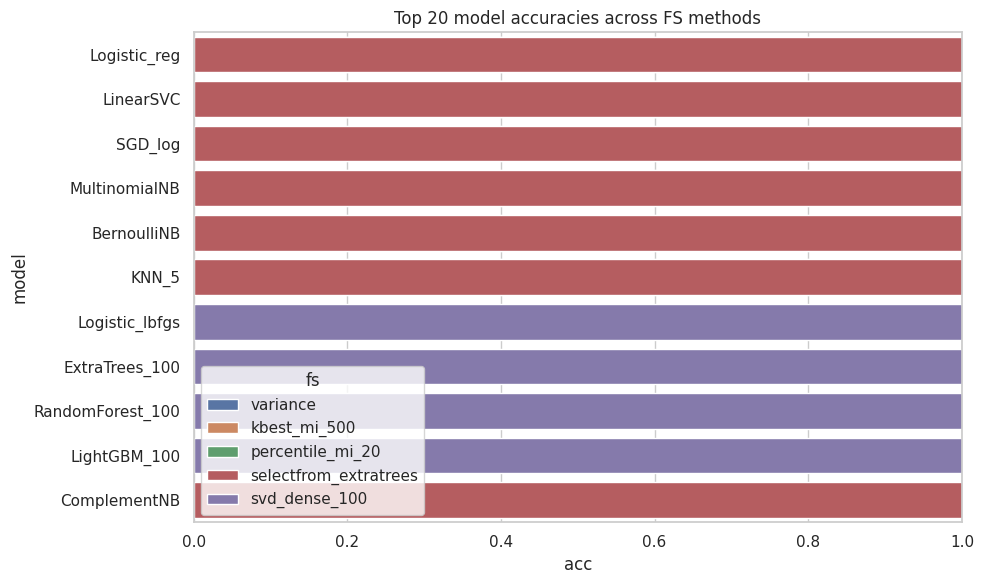

Best overall: {'fs': 'variance', 'model': 'Logistic_reg', 'acc': 1.0, 'time_s': 13.63309907913208, 'fs_shape': (80000, 1611)}
Loading best saved model...
Best model test accuracy: 1.0


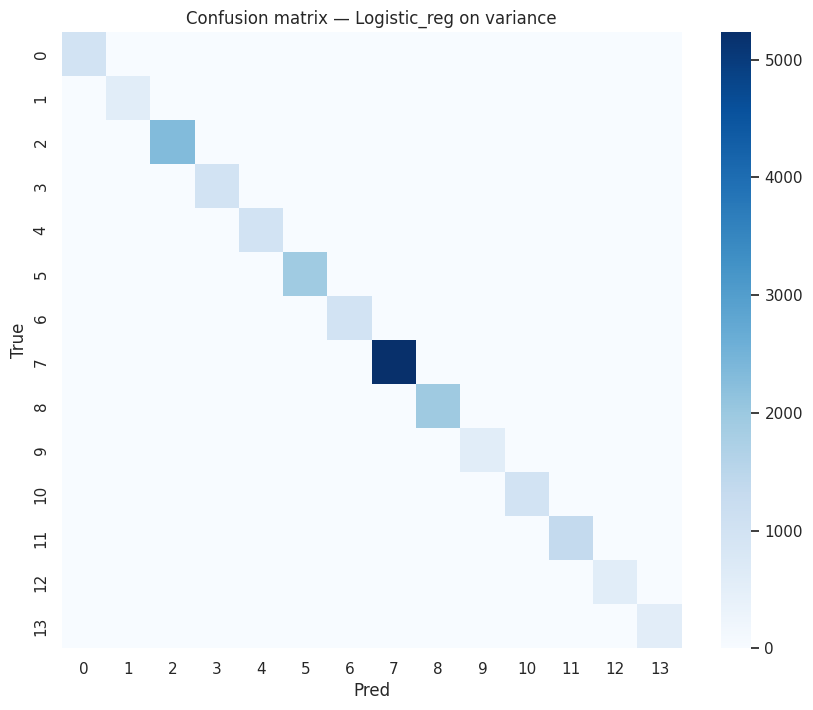

Label mapping (index -> label):
0 Apple Scab
1 Bacterial Spot
2 Black Rot
3 Cedar Apple Rust
4 Common Rust
5 Early Blight
6 Gray Leaf Spot
7 Healthy
8 Late Blight
9 Leaf Mold
10 Northern Leaf Blight
11 Powdery Mildew
12 Septoria Leaf Spot
13 Tomato Yellow Leaf Curl Virus


In [17]:
!pip install -q lightgbm

import os, time, json, traceback
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, SelectPercentile, SelectFromModel
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# --------- Config ----------
csv_path = "plant_disease_data.csv"
text_col = "symptom_description"
label_col = "disease_name"
RANDOM_STATE = 42
TEST_SIZE = 0.2
SVD_COMPONENTS = 100   # dense projection size (smaller for speed)
SAVE_DIR = Path("text_model_artifacts"); SAVE_DIR.mkdir(exist_ok=True)

# --------- Load data ----------
df = pd.read_csv(csv_path)
# quick check
print("Columns:", df.columns.tolist())
assert text_col in df.columns and label_col in df.columns, f"CSV must contain {text_col} and {label_col}"

# small cleaning
def clean_text(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    # basic cleanup: remove punctuation , collapse whitespace
    s = "".join(ch if (ch.isalnum() or ch.isspace()) else " " for ch in s)
    s = " ".join(s.split())
    return s

df['text_clean'] = df[text_col].apply(clean_text)
print("Sample cleaned:", df[['text_clean', label_col]].head(3).to_dict(orient='records'))

# --------- Encode labels ----------
le = LabelEncoder()
y = le.fit_transform(df[label_col].astype(str))
labels = le.classes_
print("Num classes:", len(labels))

# --------- Train/test split ----------
X_text = df['text_clean'].values
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("Train/test sizes:", len(X_train_text), len(X_test_text))

# --------- TF-IDF (sparse) ----------
tfv = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
print("Fitting TF-IDF ...")
t0 = time.time()
X_train_tfidf = tfv.fit_transform(X_train_text)
X_test_tfidf = tfv.transform(X_test_text)
print("TF-IDF shape:", X_train_tfidf.shape, " time:", time.time()-t0)

# --------- FS methods (functions) ----------
def fs_variance(Xtr, Xte, ytr=None, thr=0.0):
    sel = VarianceThreshold(threshold=float(thr))
    Xt = sel.fit_transform(Xtr)
    Xv = sel.transform(Xte)
    return Xt, Xv, sel

def fs_selectkbest_mi(Xtr, Xte, ytr, k=500):
    k = min(k, Xtr.shape[1])
    sel = SelectKBest(score_func=mutual_info_classif, k=k)
    Xt = sel.fit_transform(Xtr, ytr)
    Xv = sel.transform(Xte)
    return Xt, Xv, sel

def fs_percentile_mi(Xtr, Xte, ytr, perc=20):
    sel = SelectPercentile(score_func=mutual_info_classif, percentile=perc)
    Xt = sel.fit_transform(Xtr, ytr)
    Xv = sel.transform(Xte)
    return Xt, Xv, sel

def fs_svd_dense(Xtr, Xte, n_comp=SVD_COMPONENTS):
    svd = TruncatedSVD(n_components=int(n_comp), random_state=RANDOM_STATE)
    Xt = svd.fit_transform(Xtr)
    Xv = svd.transform(Xte)
    return Xt, Xv, svd

def fs_selectfrom_et(Xtr, Xte, ytr, n_estimators=200):
    et = ExtraTreesClassifier(n_estimators=n_estimators, n_jobs=-1, random_state=RANDOM_STATE)
    et.fit(Xtr, ytr)
    sel = SelectFromModel(et, prefit=True, threshold='median')
    Xt = sel.transform(Xtr)
    Xv = sel.transform(Xte)
    return Xt, Xv, sel

fs_methods = {
    "variance": lambda Xtr,Xte,ytr: fs_variance(Xtr,Xte,ytr,thr=0.0),
    "kbest_mi_500": lambda Xtr,Xte,ytr: fs_selectkbest_mi(Xtr,Xte,ytr,k=500),
    "percentile_mi_20": lambda Xtr,Xte,ytr: fs_percentile_mi(Xtr,Xte,ytr,perc=20),
    "svd_dense_100": lambda Xtr,Xte,ytr: fs_svd_dense(Xtr,Xte,n_comp=SVD_COMPONENTS),
    "selectfrom_extratrees": lambda Xtr,Xte,ytr: fs_selectfrom_et(Xtr,Xte,ytr,n_estimators=200)
}

# --------- Models (10 efficient text models) ----------
models_sparse = {
    "Logistic_reg": LogisticRegression(solver="saga", max_iter=1200, n_jobs=-1),
    "LinearSVC": LinearSVC(max_iter=5000),
    "SGD_log": SGDClassifier(loss="log_loss", max_iter=1000, tol=1e-3),
    "MultinomialNB": MultinomialNB(),
    "ComplementNB": ComplementNB(),
    "BernoulliNB": BernoulliNB(),
    "KNN_5": KNeighborsClassifier(n_neighbors=5)
}

models_dense = {
    "Logistic_lbfgs": LogisticRegression(solver="lbfgs", max_iter=1000),
    "RandomForest_100": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    "ExtraTrees_100": ExtraTreesClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
}

# LightGBM if available
try:
    from lightgbm import LGBMClassifier
    models_dense["LightGBM_100"] = LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE)
    print("LightGBM available and added.")
except Exception:
    print("LightGBM not available (skipping).")

# ---------- Training loop ----------
results = []
RUN_START = time.time()
MAX_TIME_PER_MODEL = 300  # seconds limit (not forcibly enforced, used for logging)
for fs_name, fs_fn in fs_methods.items():
    print("\n" + "="*70)
    print("FS method:", fs_name)
    try:
        # FS may return sparse or dense
        Xtr_sel, Xte_sel, sel_obj = fs_fn(X_train_tfidf, X_test_tfidf, y_train)
        print("Selected shape:", getattr(Xtr_sel, "shape", None))
    except Exception as e:
        traceback.print_exc()
        print("FS failed:", e)
        continue

    # If FS returned dense array (e.g., SVD), use dense models; else use sparse models.
    is_sparse = not isinstance(Xtr_sel, np.ndarray)
    # We'll convert label arrays to y_train/y_test as-is
    # 1) Run sparse-friendly models on sparse rep
    if is_sparse:
        for mname, mclf in models_sparse.items():
            # Skip Multinomial/Complement if negative values present (shouldn't for TF-IDF)
            try:
                t0 = time.time()
                print(f"  Training {mname} ...", end=" ", flush=True)
                # Multinomial/Complement require non-negative inputs; TF-IDF is non-negative
                mclf.fit(Xtr_sel, y_train)
                ypred = mclf.predict(Xte_sel)
                acc = accuracy_score(y_test, ypred)
                tdelta = time.time() - t0
                print(f"done | acc: {acc:.4f} | time: {tdelta:.1f}s")
                results.append({"fs":fs_name, "model":mname, "acc":acc, "time_s":tdelta, "fs_shape":Xtr_sel.shape})
                # save model artifact small
                joblib.dump(mclf, SAVE_DIR/f"{fs_name}__{mname}.joblib")
            except Exception as e:
                print(f"  {mname} failed:", str(e)[:200])
                traceback.print_exc()
                results.append({"fs":fs_name, "model":mname, "acc":None, "time_s":None, "error":str(e)[:200]})
    else:
        # dense array -> run dense models (they expect numpy arrays)
        Xtr_dense = np.asarray(Xtr_sel)
        Xte_dense = np.asarray(Xte_sel)
        for mname, mclf in models_dense.items():
            try:
                t0 = time.time()
                print(f"  Training {mname} ...", end=" ", flush=True)
                mclf.fit(Xtr_dense, y_train)
                ypred = mclf.predict(Xte_dense)
                acc = accuracy_score(y_test, ypred)
                tdelta = time.time() - t0
                print(f"done | acc: {acc:.4f} | time: {tdelta:.1f}s")
                results.append({"fs":fs_name, "model":mname, "acc":acc, "time_s":tdelta, "fs_shape":Xtr_dense.shape})
                joblib.dump(mclf, SAVE_DIR/f"{fs_name}__{mname}.joblib")
            except Exception as e:
                print(f"  {mname} failed:", str(e)[:200])
                traceback.print_exc()
                results.append({"fs":fs_name, "model":mname, "acc":None, "time_s":None, "error":str(e)[:200]})

# ---------- Summary ----------
df_res = pd.DataFrame(results)
print("\nTraining finished. Total time(s):", round(time.time()-RUN_START,1))
display(df_res.sort_values(['fs','acc'], ascending=[True, False]).reset_index(drop=True))
df_res.to_csv(SAVE_DIR/"training_summary_text_models.csv", index=False)
print("Saved summary to", SAVE_DIR/"training_summary_text_models.csv")

# ---------- Plot overall best per FS ----------
if not df_res['acc'].isnull().all():
    plt.figure(figsize=(10,6))
    order = df_res.sort_values('acc', ascending=False).dropna().head(20)
    sns.barplot(data=order, x='acc', y='model', hue='fs', dodge=False)
    plt.xlim(0,1)
    plt.title("Top 20 model accuracies across FS methods")
    plt.tight_layout()
    plt.show()

# ---------- Find single best model and show confusion matrix ----------
best_row = df_res.dropna(subset=['acc']).sort_values('acc', ascending=False).iloc[0]
print("Best overall:", best_row.to_dict())
best_fs = best_row['fs']; best_model_name = best_row['model']
print("Loading best saved model...")
best_model_path = SAVE_DIR/f"{best_fs}__{best_model_name}.joblib"
best_model = joblib.load(best_model_path)

# Reconstruct test representation for this FS and compute confusion matrix
Xtr_sel, Xte_sel, _ = fs_methods[best_fs](X_train_tfidf, X_test_tfidf, y_train)
if isinstance(Xte_sel, np.ndarray):
    ypred = best_model.predict(Xte_sel)
else:
    ypred = best_model.predict(Xte_sel)
acc = accuracy_score(y_test, ypred)
print("Best model test accuracy:", acc)
cm = confusion_matrix(y_test, ypred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title(f"Confusion matrix — {best_model_name} on {best_fs}")
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

print("Label mapping (index -> label):")
for i,l in enumerate(le.classes_):
    print(i, l)


In [21]:
# Colab / Notebook cell: Load best model + vectorizer and predict new text(s)
!pip install -q joblib lightgbm scikit-learn

import os, time, json, joblib, traceback
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from google.colab import files   # if not on Colab, remove and use alternative upload
from IPython.display import display, HTML

SAVE_DIR = Path("text_model_artifacts")
CSV_PATH = Path("plant_disease_data.csv")   # used to rebuild vectorizer/labels if needed
SAVE_DIR.mkdir(exist_ok=True)

# -------------- helpers --------------
def simple_clean(s):
    if pd.isna(s): return ""
    s = str(s).lower()
    s = "".join(ch if (ch.isalnum() or ch.isspace()) else " " for ch in s)
    s = " ".join(s.split())
    return s

# -------------- load label encoder (or rebuild) --------------
le_path = SAVE_DIR / "label_encoder.joblib"
if le_path.exists():
    le = joblib.load(le_path)
    print("Loaded LabelEncoder from", le_path)
else:
    # try to build from CSV
    if CSV_PATH.exists():
        df = pd.read_csv(CSV_PATH)
        if "disease_name" in df.columns:
            labels = df["disease_name"].astype(str).unique()
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder().fit(labels)
            joblib.dump(le, le_path)
            print("Built LabelEncoder from CSV and saved to", le_path)
        else:
            raise FileNotFoundError("No saved label encoder and CSV doesn't contain 'disease_name'.")
    else:
        raise FileNotFoundError("No label encoder and CSV not found to rebuild it.")

# -------------- load or build TF-IDF vectorizer --------------
tfv_path = SAVE_DIR / "tfidf.joblib"
if tfv_path.exists():
    tfv = joblib.load(tfv_path)
    print("Loaded TF-IDF vectorizer from", tfv_path)
else:
    if CSV_PATH.exists():
        print("TF-IDF vectorizer not found. Rebuilding TF-IDF from", CSV_PATH, " (may take a moment)...")
        df = pd.read_csv(CSV_PATH)
        if "symptom_description" not in df.columns:
            raise ValueError("CSV missing 'symptom_description' column required to rebuild TF-IDF.")
        texts = df["symptom_description"].fillna("").astype(str).map(simple_clean).tolist()
        tfv = TfidfVectorizer(max_features=50000, ngram_range=(1,2), min_df=2)
        tfv.fit(texts)
        joblib.dump(tfv, tfv_path)
        print("Built & saved TF-IDF to", tfv_path)
    else:
        raise FileNotFoundError("No TF-IDF saved and CSV not available to rebuild.")

# -------------- pick the best saved model ----------
# We'll scan SAVE_DIR for artifacts saved in training loop like: "<fs_name>__<model>.joblib"
model_files = list(SAVE_DIR.glob("*.joblib"))
if not model_files:
    raise FileNotFoundError(f"No model files found in {SAVE_DIR}. Run training cell first.")
# Option: pick best by checking training summary file if exists
summary_path = SAVE_DIR / "training_summary_text_models.csv"
best_model_file = None
if summary_path.exists():
    df_sum = pd.read_csv(summary_path)
    df_valid = df_sum.dropna(subset=["acc"])
    if len(df_valid) > 0:
        best_row = df_valid.sort_values("acc", ascending=False).iloc[0]
        # try to match file name convention
        candidate = f"{best_row['fs']}__{best_row['model']}.joblib"
        cand_path = SAVE_DIR / candidate
        if cand_path.exists():
            best_model_file = cand_path
            print("Selected best model from summary:", cand_path)
# fallback: choose the most recently modified joblib
if best_model_file is None:
    model_files_sorted = sorted(model_files, key=lambda p: p.stat().st_mtime, reverse=True)
    best_model_file = model_files_sorted[0]
    print("No summary or matching best found — using most recent model:", best_model_file)

# load model
model = joblib.load(best_model_file)
print("Loaded model:", best_model_file)

# -------------- prediction helpers --------------
def prepare_texts(texts):
    # clean input texts then vectorize
    cleaned = [simple_clean(t) for t in texts]
    X = tfv.transform(cleaned)
    return cleaned, X

def predict_texts(texts, top_k=3):
    cleaned, X = prepare_texts(texts)
    out = []
    # If model supports predict_proba
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X)
        for i, p in enumerate(probs):
            top_idx = np.argsort(p)[-top_k:][::-1]
            labels = [le.classes_[int(idx)] if hasattr(le, "classes_") else str(idx) for idx in top_idx]
            confidences = [float(p[int(idx)]) for idx in top_idx]
            print(f"\nText #{i+1}: {cleaned[i]}")
            for lab, conf in zip(labels, confidences):
                print(f"  → {lab} ({conf:.4f})")
            out.append({"text": cleaned[i], "top": list(zip(labels, confidences))})
    else:
        # only predict label (no probs)
        preds = model.predict(X)
        for i, pr in enumerate(preds):
            label = le.inverse_transform([pr])[0] if hasattr(le, "classes_") else str(pr)
            print(f"\nText #{i+1}: {cleaned[i]}")
            print(f"  → {label} (no probability available)")
            out.append({"text": cleaned[i], "top": [(label, None)]})
    return out

def predict_from_upload(save_csv="predictions_out.csv"):
    print("Upload a .txt (one text per line) or .csv (symptom_description column) — choose file now.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded.")
        return None
    fname = list(uploaded.keys())[0]
    fp = Path(fname)
    if fp.suffix.lower() == ".txt":
        with open(fname, "r", encoding="utf-8") as f:
            lines = [l.strip() for l in f.readlines() if l.strip()]
        preds = predict_texts(lines, top_k=3)
        out_df = pd.DataFrame([{"text": p["text"], "pred_top1": p["top"][0][0], "pred_top1_conf": p["top"][0][1]} for p in preds])
        out_df.to_csv(save_csv, index=False)
        print("Saved predictions to", save_csv)
        files.download(save_csv)
        return out_df
    elif fp.suffix.lower() in [".csv", ".xls", ".xlsx"]:
        df_up = pd.read_csv(fname)
        if "symptom_description" not in df_up.columns and "text" not in df_up.columns:
            print("CSV missing column 'symptom_description' or 'text'. Please upload file with the text column.")
            return None
        col = "symptom_description" if "symptom_description" in df_up.columns else "text"
        texts = df_up[col].astype(str).fillna("").tolist()
        preds = predict_texts(texts, top_k=3)
        out_df = pd.DataFrame([{"text": p["text"], "pred_top1": p["top"][0][0], "pred_top1_conf": p["top"][0][1]} for p in preds])
        out_df.to_csv(save_csv, index=False)
        print("Saved predictions to", save_csv)
        files.download(save_csv)
        return out_df
    else:
        print("Unsupported file type:", fp.suffix)
        return None

# -------------- Quick interactive examples --------------
print("\nExamples — run predict_texts(['my leaf has white spots', 'stems healthy']) to try inline.")
print("To upload a batch file and predict, run predict_from_upload().")


Built LabelEncoder from CSV and saved to text_model_artifacts/label_encoder.joblib
TF-IDF vectorizer not found. Rebuilding TF-IDF from plant_disease_data.csv  (may take a moment)...
Built & saved TF-IDF to text_model_artifacts/tfidf.joblib
Selected best model from summary: text_model_artifacts/variance__Logistic_reg.joblib
Loaded model: text_model_artifacts/variance__Logistic_reg.joblib

Examples — run predict_texts(['my leaf has white spots', 'stems healthy']) to try inline.
To upload a batch file and predict, run predict_from_upload().
